In [36]:
!rm -rf /kaggle/working/*

In [37]:
!pip install moviepy
!pip install autokeras
!pip install --upgrade keras_nlp
# Fix for the plotting in Kaggle 
!pip install pydot
!apt-get install -y graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 122 not upgraded.


In [38]:
import tensorflow as tf
import os
import glob
import cv2
import shutil
import torchaudio
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import *
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
import autokeras as ak
from tensorflow.keras.models import save_model
from moviepy.video.io.VideoFileClip import VideoFileClip
import librosa
from sklearn.model_selection import train_test_split
import h5py

In [39]:
# Setting up paths
base_path = "/kaggle/input"
src_dir_real = "/kaggle/input/Celeb-real"
src_dir_fake = "/kaggle/input/Celeb-synthesis"
src_dir_yt = "/kaggle/input/YouTube-real"
dest_dir_real = "/kaggle/working/dataset/real"
dest_dir_fake = "/kaggle/working/dataset/fake"
dest_dataset_root = "/kaggle/working/dataset"

In [40]:
os.listdir(base_path)

['YouTube-real', 'Celeb-synthesis', 'Celeb-real', 'List_of_testing_videos.txt']

In [41]:
# Creating destination directories - if ignored, throws error while saving files
os.makedirs(dest_dir_real, exist_ok=True)
os.makedirs(dest_dir_fake, exist_ok=True)

In [42]:
list_real = os.listdir(src_dir_real)
print(len(list_real))
list_fake = os.listdir(src_dir_fake)
print(len(list_fake))
list_yt = os.listdir(src_dir_yt)
print(len(list_yt))

590
5639
300


In [43]:
# List of real videos in dataset

# Copying real files path to from source to destination
for filename in list_real:
    src_file = os.path.join(src_dir_real, filename)
    dest_file = os.path.join(dest_dir_real, filename)
    shutil.copy(src_file, dest_file)

for filename in list_yt:
    src_file = os.path.join(src_dir_yt, filename)
    dest_file = os.path.join(dest_dir_real, filename)
    shutil.copy(src_file, dest_file)

# Copying fake files path to from source to destination
for filename in list_fake:
    src_file = os.path.join(src_dir_fake, filename)
    dest_file = os.path.join(dest_dir_fake, filename)
    shutil.copy(src_file, dest_file)

print("Files copied successfully!")
print(len(os.listdir(dest_dir_real)), len(os.listdir(dest_dir_fake)))

Files copied successfully!
890 5639


Why extract audio?

Deepfake videos often exhibit inconsistencies not just in visual cues but also in audio. By analyzing the audio component, the model can detect anomalies such as unnatural speech patterns, mismatches between lip movements and speech, or synthetic voice artifacts. Incorporating audio analysis enhances the model's ability to detect deepfakes more accurately

In [44]:
def extract_audio_files():
    real_video_files = glob.glob(os.path.join("/kaggle/working", dataset_root, "real", "*.mp4"))
    fake_video_files = glob.glob(os.path.join("/kaggle/working", dataset_root, "fake", "*.mp4"))
    all_video_files = real_video_files + fake_video_files
    for video_file in all_video_files:

        # Load the video file using moviepy to access its frames, duration, and audio
        # This will be used for extracting audio or performing video edits
        video_clip = VideoFileClip(video_file)

        # Load the video file and extract its audio component for further processing
        audio_clip = video_clip.audio
        output_audio_path = os.path.splitext(video_file)[0] + ".wav"
        audio_clip.write_audiofile(output_audio_path, codec+'pcm_s16le')

**Loading and Extracting Video frames**

In [45]:
def extract_video_frames(video_path, image_size, num_frames = 10):
    # Loading video file
    video_capture = cv2.VideoCapture(video_path)
    # Get the total number of frames in the video
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # print(f"Frame Count : {frame_count}")
    
    frames = []

    # Loop through the video and extract up to 'num_frames' frames
    for frame_num in range(min(frame_count, num_frames)):
        ret, frame = video_capture.read()  # Read the next frame
        if not ret:   # If frame not read successfully, exit loop
            break

        # Converting frames from BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Resizing images to parameter image_size
        frame = cv2.resize(frame, image_size)
        frames.append(frame)
    # Returning processed frames
    return frames

In [46]:
dataset_root = "/kaggle/working/dataset"

real_video_paths = glob.glob(os.path.join(dataset_root, "real", "*.mp4"))
fake_video_paths = glob.glob(os.path.join(dataset_root, "fake", "*.mp4"))

# Frame image size
image_size = (64, 64)
num_samples = 100

print(len(real_video_paths), len(fake_video_paths))

# Extracting images(X = features) from video clips
#X_images_real = [extract_video_frames(video_p0ath, image_size) for video_path in real_video_paths]
#X_images_fake = [extract_video_frames(video_path, image_size) for video_path in fake_video_paths]
def extract_video_frames_safe(video_path, image_size, num_frames=10):
    frames = extract_video_frames(video_path, image_size, num_frames)
    return frames if len(frames) == num_frames else None

X_images = []
Y_labels = []

for video_path in real_video_paths:
    frames = extract_video_frames_safe(video_path, image_size)
    if frames is not None:
        X_images.append(frames)
        Y_labels.append(0)  # Real → 0

for video_path in fake_video_paths:
    frames = extract_video_frames_safe(video_path, image_size)
    if frames is not None:
        X_images.append(frames)
        Y_labels.append(1)  # Fake → 1

X_images = np.array(X_images)
Y_labels = np.array(Y_labels)

890 5639


In [47]:
print("Valid videos:", len(X_images))
print("Valid labels:", len(Y_labels))

Valid videos: 6528
Valid labels: 6528


In [48]:
print(X_images.shape, Y_labels.shape)

(6528, 10, 64, 64, 3) (6528,)


In [49]:
# Using random seed as 42
X_images_train, X_images_test, Y_labels_train, Y_labels_test = train_test_split(
    X_images, Y_labels, test_size = 0.2, random_state = 42, shuffle=True
)

In [50]:
print("X_images_train shape:", X_images_train.shape)
print("X_images_test shape:", X_images_test.shape)
print("Y_train shape:", Y_labels_train.shape)
print("Y_test shape:", Y_labels_test.shape)

X_images_train shape: (5222, 10, 64, 64, 3)
X_images_test shape: (1306, 10, 64, 64, 3)
Y_train shape: (5222,)
Y_test shape: (1306,)


In [51]:
# Save the data in a HDF5 file
h5_path = '/kaggle/working/dataset/data.h5'

if os.path.exists(h5_path):
    os.remove(h5_path)
    print("Deleted data.h5")
else:
    print("data.h5 not found")

# Save the data in a HDF5 file for faster processing and beter RAM utilization
h5_file = h5py.File('/kaggle/working/dataset/data.h5', 'w')

h5_file.create_dataset('X_images_train', data=X_images_train)
h5_file.create_dataset('X_images_test', data=X_images_test)
h5_file.create_dataset('y_labels_train', data=Y_labels_train)
h5_file.create_dataset('y_labels_test', data=Y_labels_test)

# Close the HDF5 file
h5_file.close()
print("Successfully loaded data into file!")

data.h5 not found
Successfully loaded data into file!


In [52]:
# Flush out the heavily loaded variables from memory
del X_images_train
del X_images_test
del Y_labels_train
del Y_labels_test

In [53]:
import gc
gc.collect()

8

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12288)               │       1,585,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,594,176 (6.08 MB)

 Trainable params: 1,594,176 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64, 64, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64, 64, 1)           │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,833 (34.50 KB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 64, 64, 3)           │       1,594,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 64, 64, 1)           │           8,833 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,603,009 (6.11 MB)

 Trainable params: 1,594,176 (6.08 MB)

 Non-trainable params: 8,833 (34.50 KB)

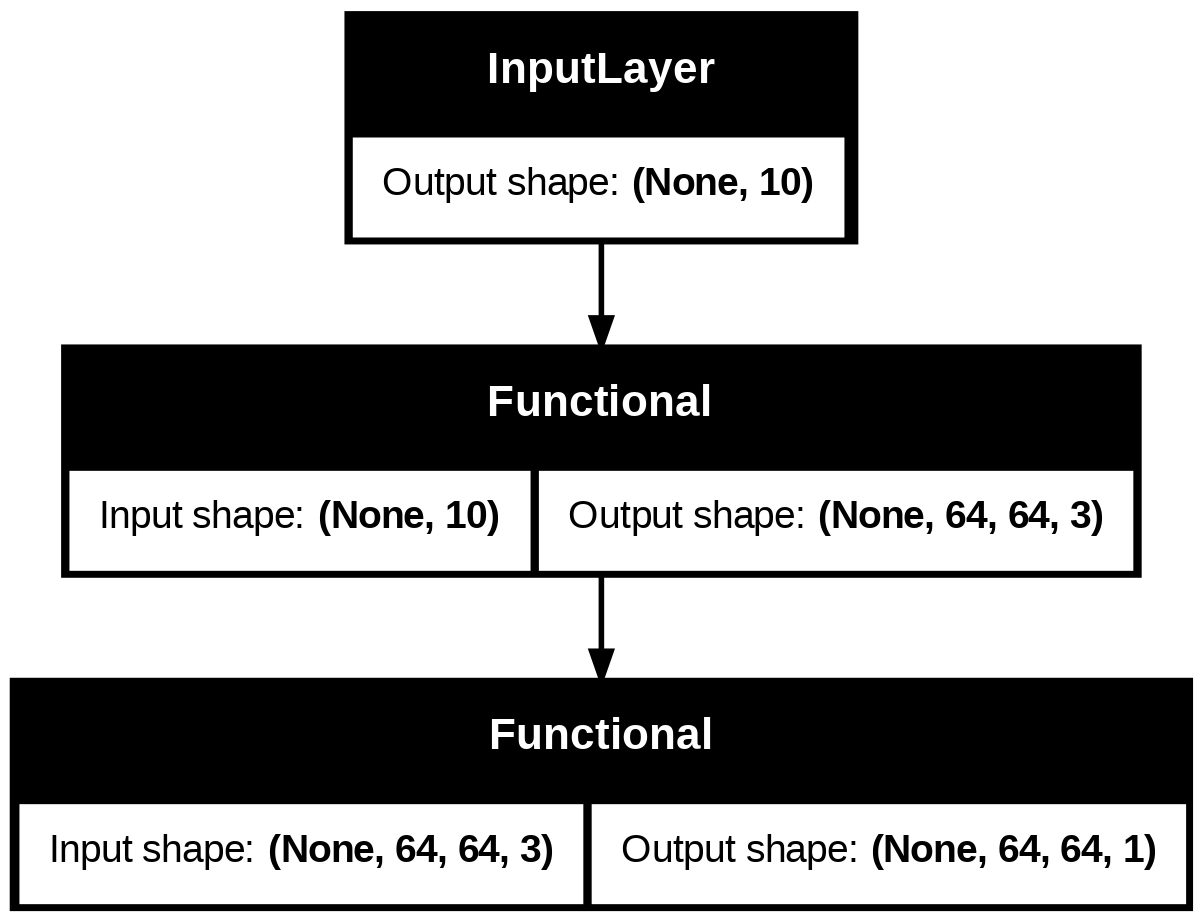

In [54]:
latent_dim = 10
image_shape = (64, 64, 3)
output_shape = (64, 64, 3)

# Build the Generator model
def build_generator(latent_dim, output_shape):
    generator_input = Input(shape=(latent_dim,))
    x = Dense(64)(generator_input)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)

    # Calculate the number of units in the Dense layer for the generator output
    num_units = output_shape[0] * output_shape[1] * output_shape[2]

    # Generator output with a Dense layer and reshape
    generated_data = Dense(num_units, activation='tanh')(x)
    generated_data = Reshape(output_shape)(generated_data)

    generator = Model(generator_input, generated_data)
    return generator

# Build the Discriminator model
def build_discriminator(input_shape):
    discriminator_input = Input(shape=input_shape)
    x = Dense(128)(discriminator_input)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    validity = Dense(1, activation='sigmoid')(x)
    discriminator = Model(discriminator_input, validity)
    return discriminator

# Build the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    generated_data = generator(gan_input)
    gan_output = discriminator(generated_data)
    gan = Model(gan_input, gan_output)
    return gan

generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(output_shape)
gan = build_gan(generator, discriminator)

# Print the model summaries
generator.summary()
discriminator.summary()
gan.summary()

# Plot the model architectures
plot_model(generator, show_shapes=True, to_file="generator.png")
plot_model(discriminator, show_shapes=True, to_file="discriminator.png")
plot_model(gan, show_shapes=True, to_file="gan.png")

In [55]:
def multimodal_fusion(images, num_modalities):
    num_samples, num_frames, height, width, channels = images.shape

    # Create additional modalities by converting images to grayscale
    additional_modalities = []
    for i in range(1, num_modalities):
        modified_images = []
        for frame in range(num_frames):
            grayscale_frame = np.mean(images[:, frame], axis=-1, keepdims=True)
            modified_images.append(grayscale_frame)
        additional_modalities.append(np.array(modified_images))

    # Tile the additional modalities to match the number of frames
    tiled_modalities = [modalities[:, np.newaxis] for modalities in additional_modalities]
    tiled_modalities = [np.tile(modalities, (1, num_frames, 1, 1, 1)) for modalities in tiled_modalities]

    # Concatenate the original images and additional modalities along the channel axis
    fused_data = np.concatenate((images, *tiled_modalities), axis=-1)
    return fused_data

In [56]:
import h5py
batch_size = 40
num_modalities = 1 #Add GrayScale with RGB modality

# Load the data from the HDF5 file
h5_file = h5py.File('/kaggle/working/dataset/data.h5', 'r')
num_samples = len(h5_file['X_images_train'])
y_train = h5_file['y_labels_train'][:]

multimodal_data = []

for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    batch_X_images_train = h5_file['X_images_train'][batch_start:batch_end]
    #batch_X_images_test = h5_file['X_images_test'][batch_start:batch_end]

    # Perform multimodal fusion on the current batch
    fused_batch_X_train = multimodal_fusion(batch_X_images_train, num_modalities)
    #fused_batch_X_test = multimodal_fusion(batch_X_images_test, num_modalities)
    multimodal_data.append(fused_batch_X_train)
    print("Fused batch X_train shape:", fused_batch_X_train.shape)
    #print("Fused batch X_test shape:", fused_batch_X_test.shape)

h5_file.close()

Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X

In [57]:
import autokeras as ak
from sklearn.model_selection import train_test_split
# Stack the multimodal data
fused_X_train = np.vstack(multimodal_data)

# Get the dimensions from the shape of fused_X_train
num_samples, num_frames, height, width, channels = fused_X_train.shape

# Reshape the data to match AutoKeras expected format
reshaped_X_train = fused_X_train.reshape((-1, height, width, channels))

# Reshape again to treat each frame as a separate sample
reshaped_X_train = reshaped_X_train.reshape((-1, height, width, channels))

# Reshape y_train to match the new number of samples
reshaped_Y_train = np.repeat(y_train, num_frames, axis=0)

print("reshaped_X_train shape:", reshaped_X_train.shape)
print("reshaped_y_train shape:", reshaped_y_train.shape)

X_train, X_val, y_train, y_val = train_test_split(reshaped_X_train, reshaped_y_train, test_size=0.2, shuffle=True, random_state=42)


reshaped_X_train shape: (52220, 64, 64, 3)
reshaped_y_train shape: (52220,)


In [58]:
from sklearn.utils import class_weight
import numpy as np

# weight sampling for imbalanced classes
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(reshaped_Y_train),
    y=reshaped_y_train
)

# Convert to dictionary for Keras
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 3.7840579710144926, 1: 0.5761253309796999}


In [61]:
# Create the image-based AutoKeras model
search = ak.ImageClassifier(max_trials=2)

# Train the NAS model
history = search.fit(
    reshaped_X_train, 
    reshaped_y_train, 
    epochs=4, 
    validation_data=(X_val, y_val),
    class_weight = class_weights)
print(history.history.keys())

# Export the best model architecture
best_model = search.export_model()

Reloading Tuner from ./image_classifier/tuner0.json
Epoch 1/4
1632/1632 ━━━━━━━━━━━━━━━━━━━━ 600s 333ms/step - accuracy: 0.5028 - loss: 1.0381 - val_accuracy: 0.1307 - val_loss: 0.8963
Epoch 2/4
1632/1632 ━━━━━━━━━━━━━━━━━━━━ 536s 328ms/step - accuracy: 0.4556 - loss: 0.7294 - val_accuracy: 0.4939 - val_loss: 0.6777
Epoch 3/4
1632/1632 ━━━━━━━━━━━━━━━━━━━━ 536s 328ms/step - accuracy: 0.4497 - loss: 0.7245 - val_accuracy: 0.4929 - val_loss: 0.7363
Epoch 4/4
1632/1632 ━━━━━━━━━━━━━━━━━━━━ 536s 329ms/step - accuracy: 0.5136 - loss: 0.7303 - val_accuracy: 0.5989 - val_loss: 0.6849
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 64, 64, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Activation)   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,768 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,127 (207.53 KB)

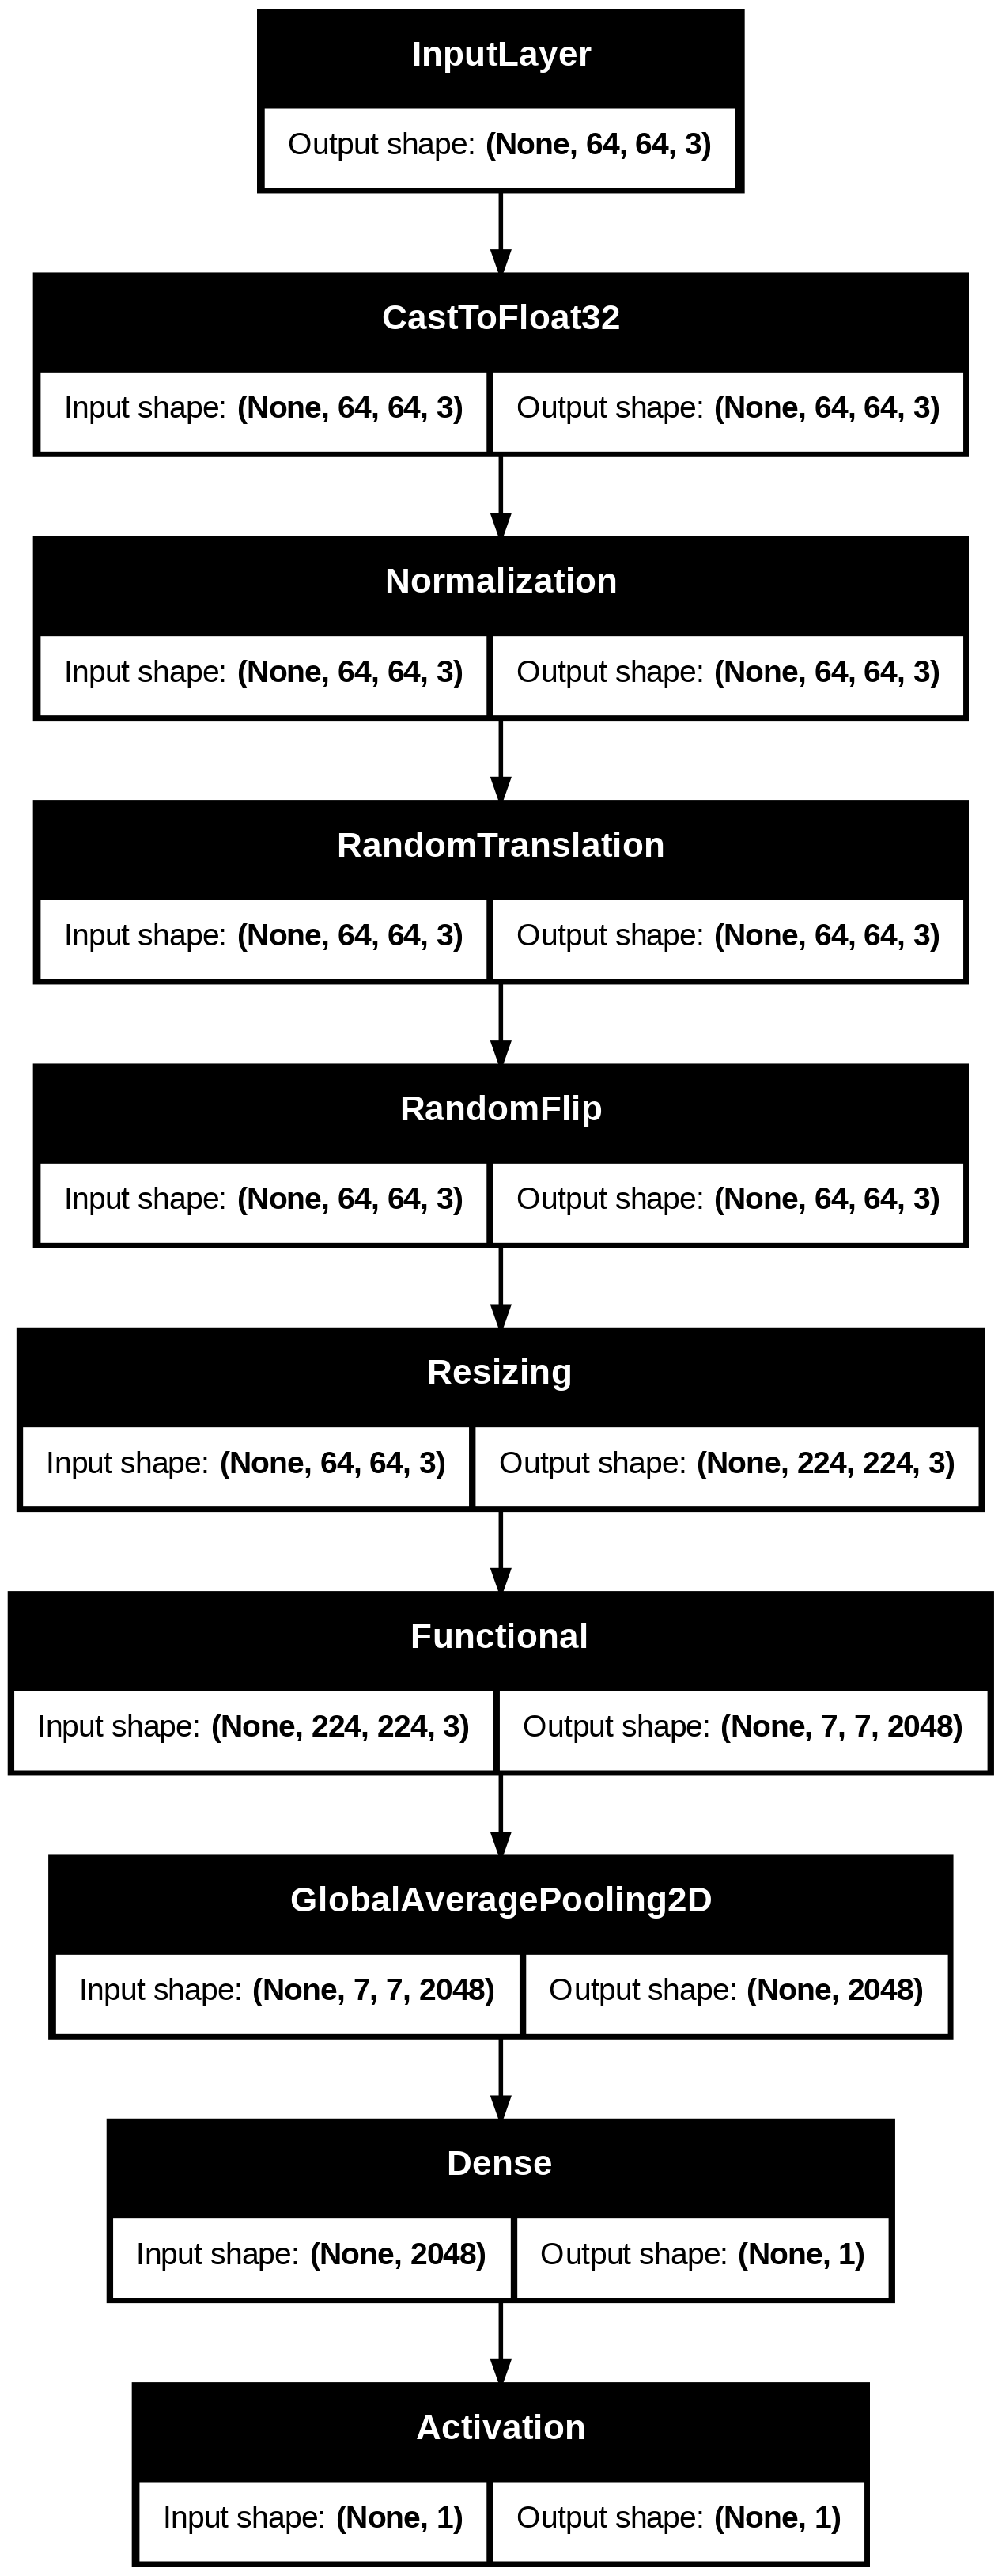

In [62]:
# Save the model
save_model(best_model, '/kaggle/working/best_model.h5')

# Print the model summary
best_model.summary()

# Plot the model architecture
plot_model(best_model, show_shapes=True, to_file="best_model.png")

In [ ]:
# Compile the best model
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 406s 338ms/step - accuracy: 0.8630 - loss: 0.4091 - val_accuracy: 0.8644 - val_loss: 0.3989
Epoch 2/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 347s 332ms/step - accuracy: 0.8677 - loss: 0.3923 - val_accuracy: 0.8644 - val_loss: 0.4199
Epoch 3/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 347s 332ms/step - accuracy: 0.8688 - loss: 0.3880 - val_accuracy: 0.8644 - val_loss: 0.3941
Epoch 4/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 346s 331ms/step - accuracy: 0.8678 - loss: 0.3882 - val_accuracy: 0.8644 - val_loss: 0.3942
Epoch 5/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 347s 332ms/step - accuracy: 0.8644 - loss: 0.3938 - val_accuracy: 0.8644 - val_loss: 0.3971
Epoch 6/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 346s 331ms/step - accuracy: 0.8665 - loss: 0.3925 - val_accuracy: 0.8644 - val_loss: 0.3936
Epoch 7/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 347s 332ms/step - accuracy: 0.8662 - loss: 0.3903 - val_accuracy: 0.8644 - val_loss: 0.3933
Epoch 8/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 347s 332ms/step - ac

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('Training History')
plt.show()

In [ ]:
# Assuming you have a trained model and test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # For multi-class classification

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_labels, target_names=['Real', 'Fake']))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# For binary classification, ensure y_test and y_pred are in the correct format
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
print(f"ROC AUC Score: {roc_auc}")